<a href="https://colab.research.google.com/github/GParolini/nrel_rsf_data/blob/main/nrel_rsf_2011_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NREL RSF 2011 DATASET

### 1- Reading the data

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
import numpy as np

In [2]:
# reading in the dataset

url= "https://data.openei.org/files/358/rsfmeasureddata2011.csv" #Dataset URL

df = pd.read_csv(url)

df = df.drop(df.columns[-1],axis=1) #The last column of the csv file is empty and generates an empty dataframe column
df #Final dataframe generated from the csv file

,Day of Week,Date and Time,Total Cooling (kW),Total Heating (kW),Total Mechanical (kW),Total Lighting (kW),Total Plug Loads (kW),Total Data Center (kW),Total Building (kW),PV (kW),Building Net (kW)
0,Saturday,1/1/2011 0:00,0,0,NaN,NaN,NaN,NaN,0,NaN,NaN
1,Saturday,1/1/2011 1:00,0,936,8.0,4.0,32.0,102.0,1080,0.0,1080.0
2,Saturday,1/1/2011 2:00,0,838,8.0,4.0,30.0,102.0,978,0.0,978.0
3,Saturday,1/1/2011 3:00,0,904,8.0,4.0,32.0,102.0,1046,0.0,1046.0
4,Saturday,1/1/2011 4:00,0,838,10.0,4.0,34.0,102.0,984,0.0,984.0
...,...,...,...,...,...,...,...,...,...,...,...
8755,Saturday,12/31/2011 19:00,0,30,4.0,12.0,30.0,92.0,168,0.0,168.0
8756,Saturday,12/31/2011 20:00,0,30,2.0,8.0,32.0,100.0,174,0.0,174.0
8757,Saturday,12/31/2011 21:00,0,58,4.0,8.0,32.0,100.0,204,0.0,204.0
8758,Saturday,12/31/2011 22:00,0,146,4.0,10.0,32.0,92.0,282,0.0,282.0


In [3]:
# Information provided by the NREL RSF dataset
df.columns

Index(['Day of Week', 'Date and Time', 'Total Cooling (kW)',
       'Total Heating (kW)', 'Total Mechanical (kW)', 'Total Lighting (kW)',
       'Total Plug Loads (kW)', 'Total Data Center (kW)',
       'Total Building (kW)', 'PV (kW)', 'Building Net (kW)'],
      dtype='object')

### 2- From power to electricity

In [4]:
# Making the Date&Time column into a datetime object
df['Date and Time'] = pd.to_datetime(df['Date and Time'])
df.dtypes

,0
Day of Week,object
Date and Time,datetime64[ns]
Total Cooling (kW),int64
Total Heating (kW),int64
Total Mechanical (kW),float64
Total Lighting (kW),float64
Total Plug Loads (kW),float64
Total Data Center (kW),float64
Total Building (kW),int64
PV (kW),float64


In [5]:
# Adding a "month column" to provide monthly statistics
df["Month"] = df['Date and Time'].dt.month

In [6]:
# Adding a "day column" to provide daily statistics
df["Day"] = df['Date and Time'].dt.day

In [7]:
# Adding a "hour column" to provide hourly statistics
df["Hour"] = df['Date and Time'].dt.hour

The dataset has only information on power. I extract the related information on electricity for the "Total Data Centre", "Total Building" and "PV" columns using linear interpolation between data points and integrating over time with the trapezoidal rule:
$ E = \sum_{i=1}^{n-1}  \frac{(P_{(i+1)} + P_{(i)})} 2 Δt_{i} $

In [8]:
# The Date and Time column is set as an index in the dataframe
df = df.set_index(["Date and Time"])

In [9]:
# Columns with the computed energy usage in kWh and the percentage of energy grid used (vs. PV energy) are added to the dataset

df["kWh Total Data Centre"] = df['Total Data Center (kW)'].rolling(2).apply(integrate.trapz)
df["kWh Total Building"] = df['Total Building (kW)'].rolling(2).apply(integrate.trapz)
df["kWh PV"] = df['PV (kW)'].rolling(2).apply(integrate.trapz) #PV power is given in the dataset as negative by convention
df["kWh Building Net"] = df['Building Net (kW)'].rolling(2).apply(integrate.trapz)
df["Percentage of Energy Grid"] = round(((df['kWh Building Net']/df['kWh Total Building'])* 100).where(df['kWh Building Net']>=0, 0),1) # Computed to understand when the building only uses PV electricity
index_lst = ["2011-01-01 00:00:00", "2011-01-01 01:00:00"] #The use of the rolling windows for trapezoidal integration creates two NaN values at the beginning of the dataset. This creates issues
df.loc[index_lst,"Percentage of Energy Grid"] = 100 #when computing the percentage of grid energy. The values are manually corrected (at night only grid energy is used)

In [10]:
df["Bool"] =(df["Percentage of Energy Grid"]).where(df["Percentage of Energy Grid"] !=0, "PV") # A column is added to identify the energy used (grid or PV during each hour)
val = [x for x in df['Bool'].tolist() if isinstance(x, (int,float))]
df["Bool"] = df['Bool'].replace(val,"Grid")

In [11]:
set(df['Bool'].tolist())

{'Grid', 'PV'}

In [12]:
# Creation of Figure 3.4. The plotly graph is interactive and overing over the graph is it possible to check in detail energy usage for every day and time in the dataset

import plotly.express as px
import plotly.graph_objects as go

color_map = {'Grid': 'grey',
              'PV': 'yellow'}

en_color = df['Bool'].map(color_map)


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Hour'],
    mode='markers',
    marker=dict(color=en_color)
))

fig.update_layout(height=500)
fig.update_layout(
            xaxis=dict(
                tickfont = dict(size=22)
            ))
fig.update_layout(
            yaxis=dict(
                title=dict(text="Hour of the Day", font=dict(size=22)),
                tickfont = dict(size=22)
                )
        )
fig.show()

### 3- Energy use of the total building and the data centre in 2011

In [13]:
# Total energy used by the building in 2011
df["kWh Total Building"].sum()

2345463.0

In [14]:
# Total energy used by the data centre in 2011
DC_total_el_2011= df["kWh Total Data Centre"].sum()
DC_total_el_2011

897587.0

In [15]:
# Total energy produced by the PV system in 2011
-df["kWh PV"].sum()

919314.0

In [16]:
# Costs associated to the NREL RSF data centre assuming only macrogrid electricity is used
el_grid_cost = 0.057 # According to the report compiled by NREL RSF staff the 2011 price paid for grid electricity
                    # was 0.057 $/KWh


tot_grid_el_cost = round(DC_total_el_2011 * el_grid_cost) # In dollars
tot_grid_el_cost

51162

In [17]:
# CO2eq emissions associated to the NREL RSF data centre if all electricity used were from the power grid
# The CO2eq coefficient has been extracted from the eGRID historical data for Colorado. The data used refer to Year 2010.
# In 2010, Colorado had a net (electricity) generation of 50759105.5 MWh and CO2eq emissions equal to 46370761.5 short tons.
# I will use these two pieces of information to extract the CO2eq coefficient for the Colorado grid electricity to calculate
# the carbon emissions associated to a use of the NREL RSF data centre from grid electricity only.

CO_CO2_tot_short_tons = 46370761.5
CO_CO2_tot_metric_tons = round(CO_CO2_tot_short_tons/1.1023, 1) # 1.1023 is the transformation factor from short to metric tons
CO_CO2_tot_metric_tons

42067278.9

In [18]:
CO_CO2_eq_coeff = round(CO_CO2_tot_metric_tons/50759105.5, 4) # Average CO2eq emission coefficient for Colorado in 2010
CO_CO2_eq_coeff # The units are metric tons/MWh, but the coefficient does not change moving to kg/kWh
                # The coefficient is rather high because Colorado belongs to a grid where soft coal was often
                # used to generate electricity in the early 2010s as it was cheap and abundant.

0.8288

In [19]:
DC_tot_CO2eq_emissions = round((CO_CO2_eq_coeff * DC_total_el_2011)/1000, 1) #emissions in metric tons
DC_tot_CO2eq_emissions

743.9

### 4- Daily data on energy consumed (by the data centre and the entire building) and produced (by the photovoltaic system)

In [20]:
# Electricity produced by the PV (daily)
daily_PV_el = df['kWh PV'].resample("D").sum()

In [21]:
# Electricity needed by the data centre (daily)
daily_DC_el = df['kWh Total Data Centre'].resample("D").sum()

In [22]:
# Electricity needed by the entire building (daily)
daily_Building_el = df['kWh Total Building'].resample("D").sum()

In [23]:
# Dataframe created to compare DC energy use, Total Building energy use, PV energy production
df_daily_comparison = pd.merge(pd.merge(daily_DC_el,daily_PV_el,left_index=True, right_index=True), daily_Building_el , left_index=True, right_index=True)

In [24]:
# Column added to the daily comparison dataframe to pinpoint the Net Zero days (PV production higher than Total Building requirements)
df_daily_comparison["Net Zero"] = np.where((-df_daily_comparison['kWh PV'] >= df_daily_comparison['kWh Total Building']), df_daily_comparison['kWh Total Building']+df_daily_comparison['kWh PV'], np.nan)

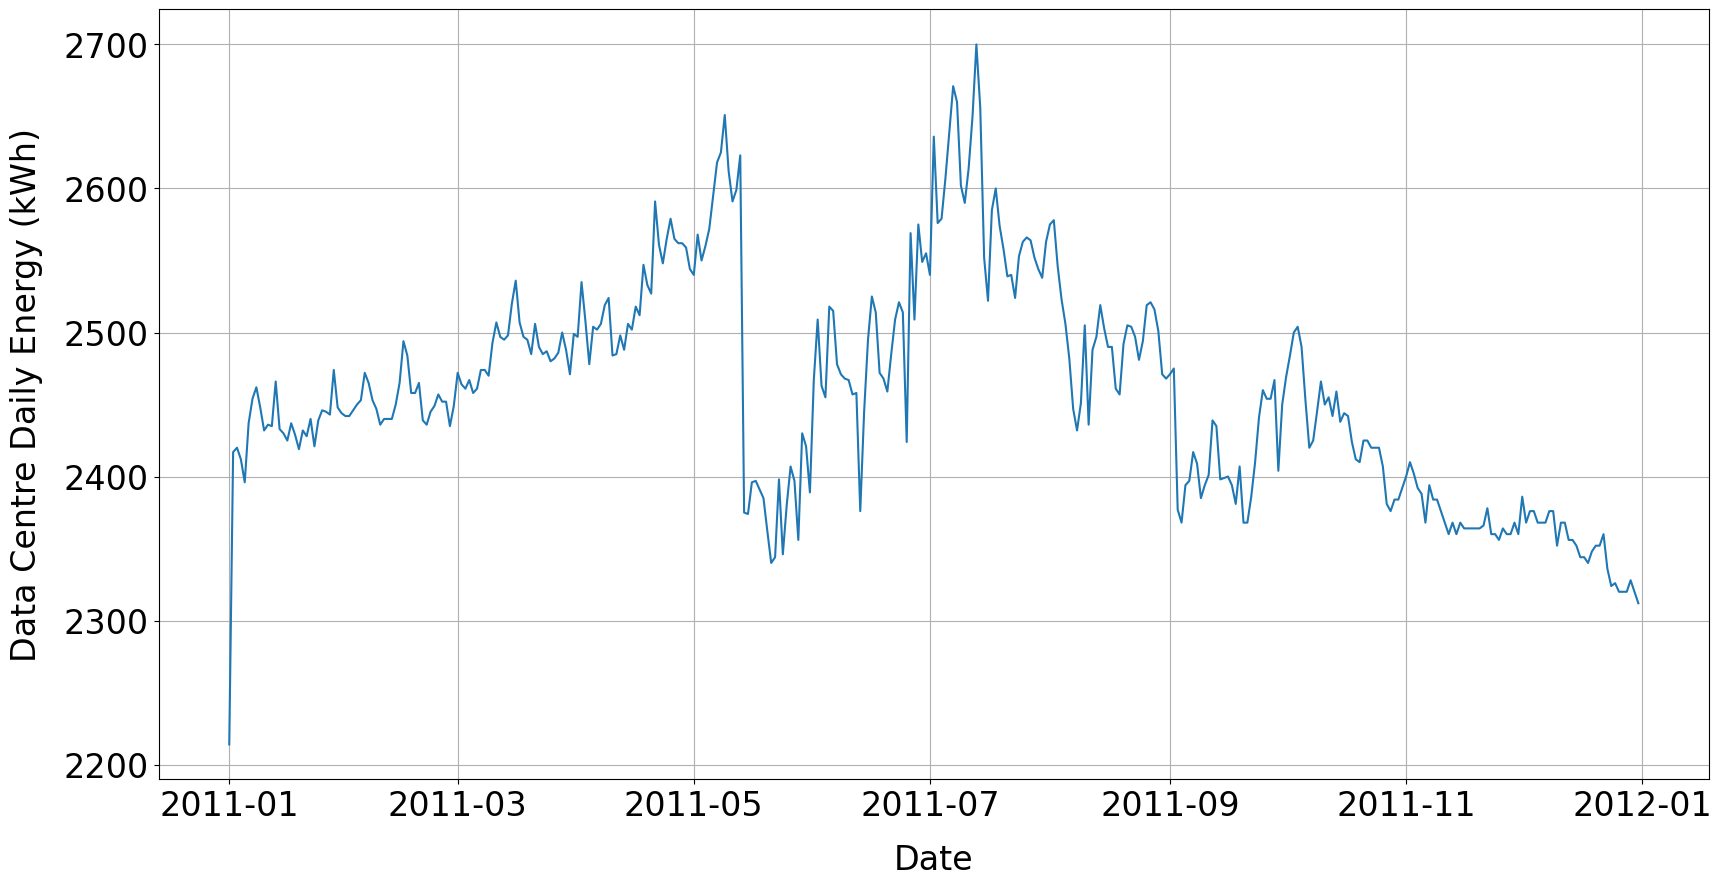

In [25]:
# Creation of Figure 3.3: Daily electricity requirements of the NREL RSF data centre.

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(df_daily_comparison['kWh Total Data Centre'])
plt.xticks(fontsize="24")
plt.yticks(fontsize="24")
plt.xlabel("Date", fontsize="24", labelpad=15)
plt.ylabel("Data Centre Daily Energy (kWh)", fontsize="24", labelpad=15)
plt.savefig("data_centre_daily_load.jpg", dpi=300);

### 5- Taking a closer look at the Data Centre electricity consumption

In [26]:
# Creating a dataframe for each of the months (all dataframe names are in the format df_i with i=1, ...12)

for i in range(1,13):
  globals()[f"df_{i}"] = df[df['Month']==i]



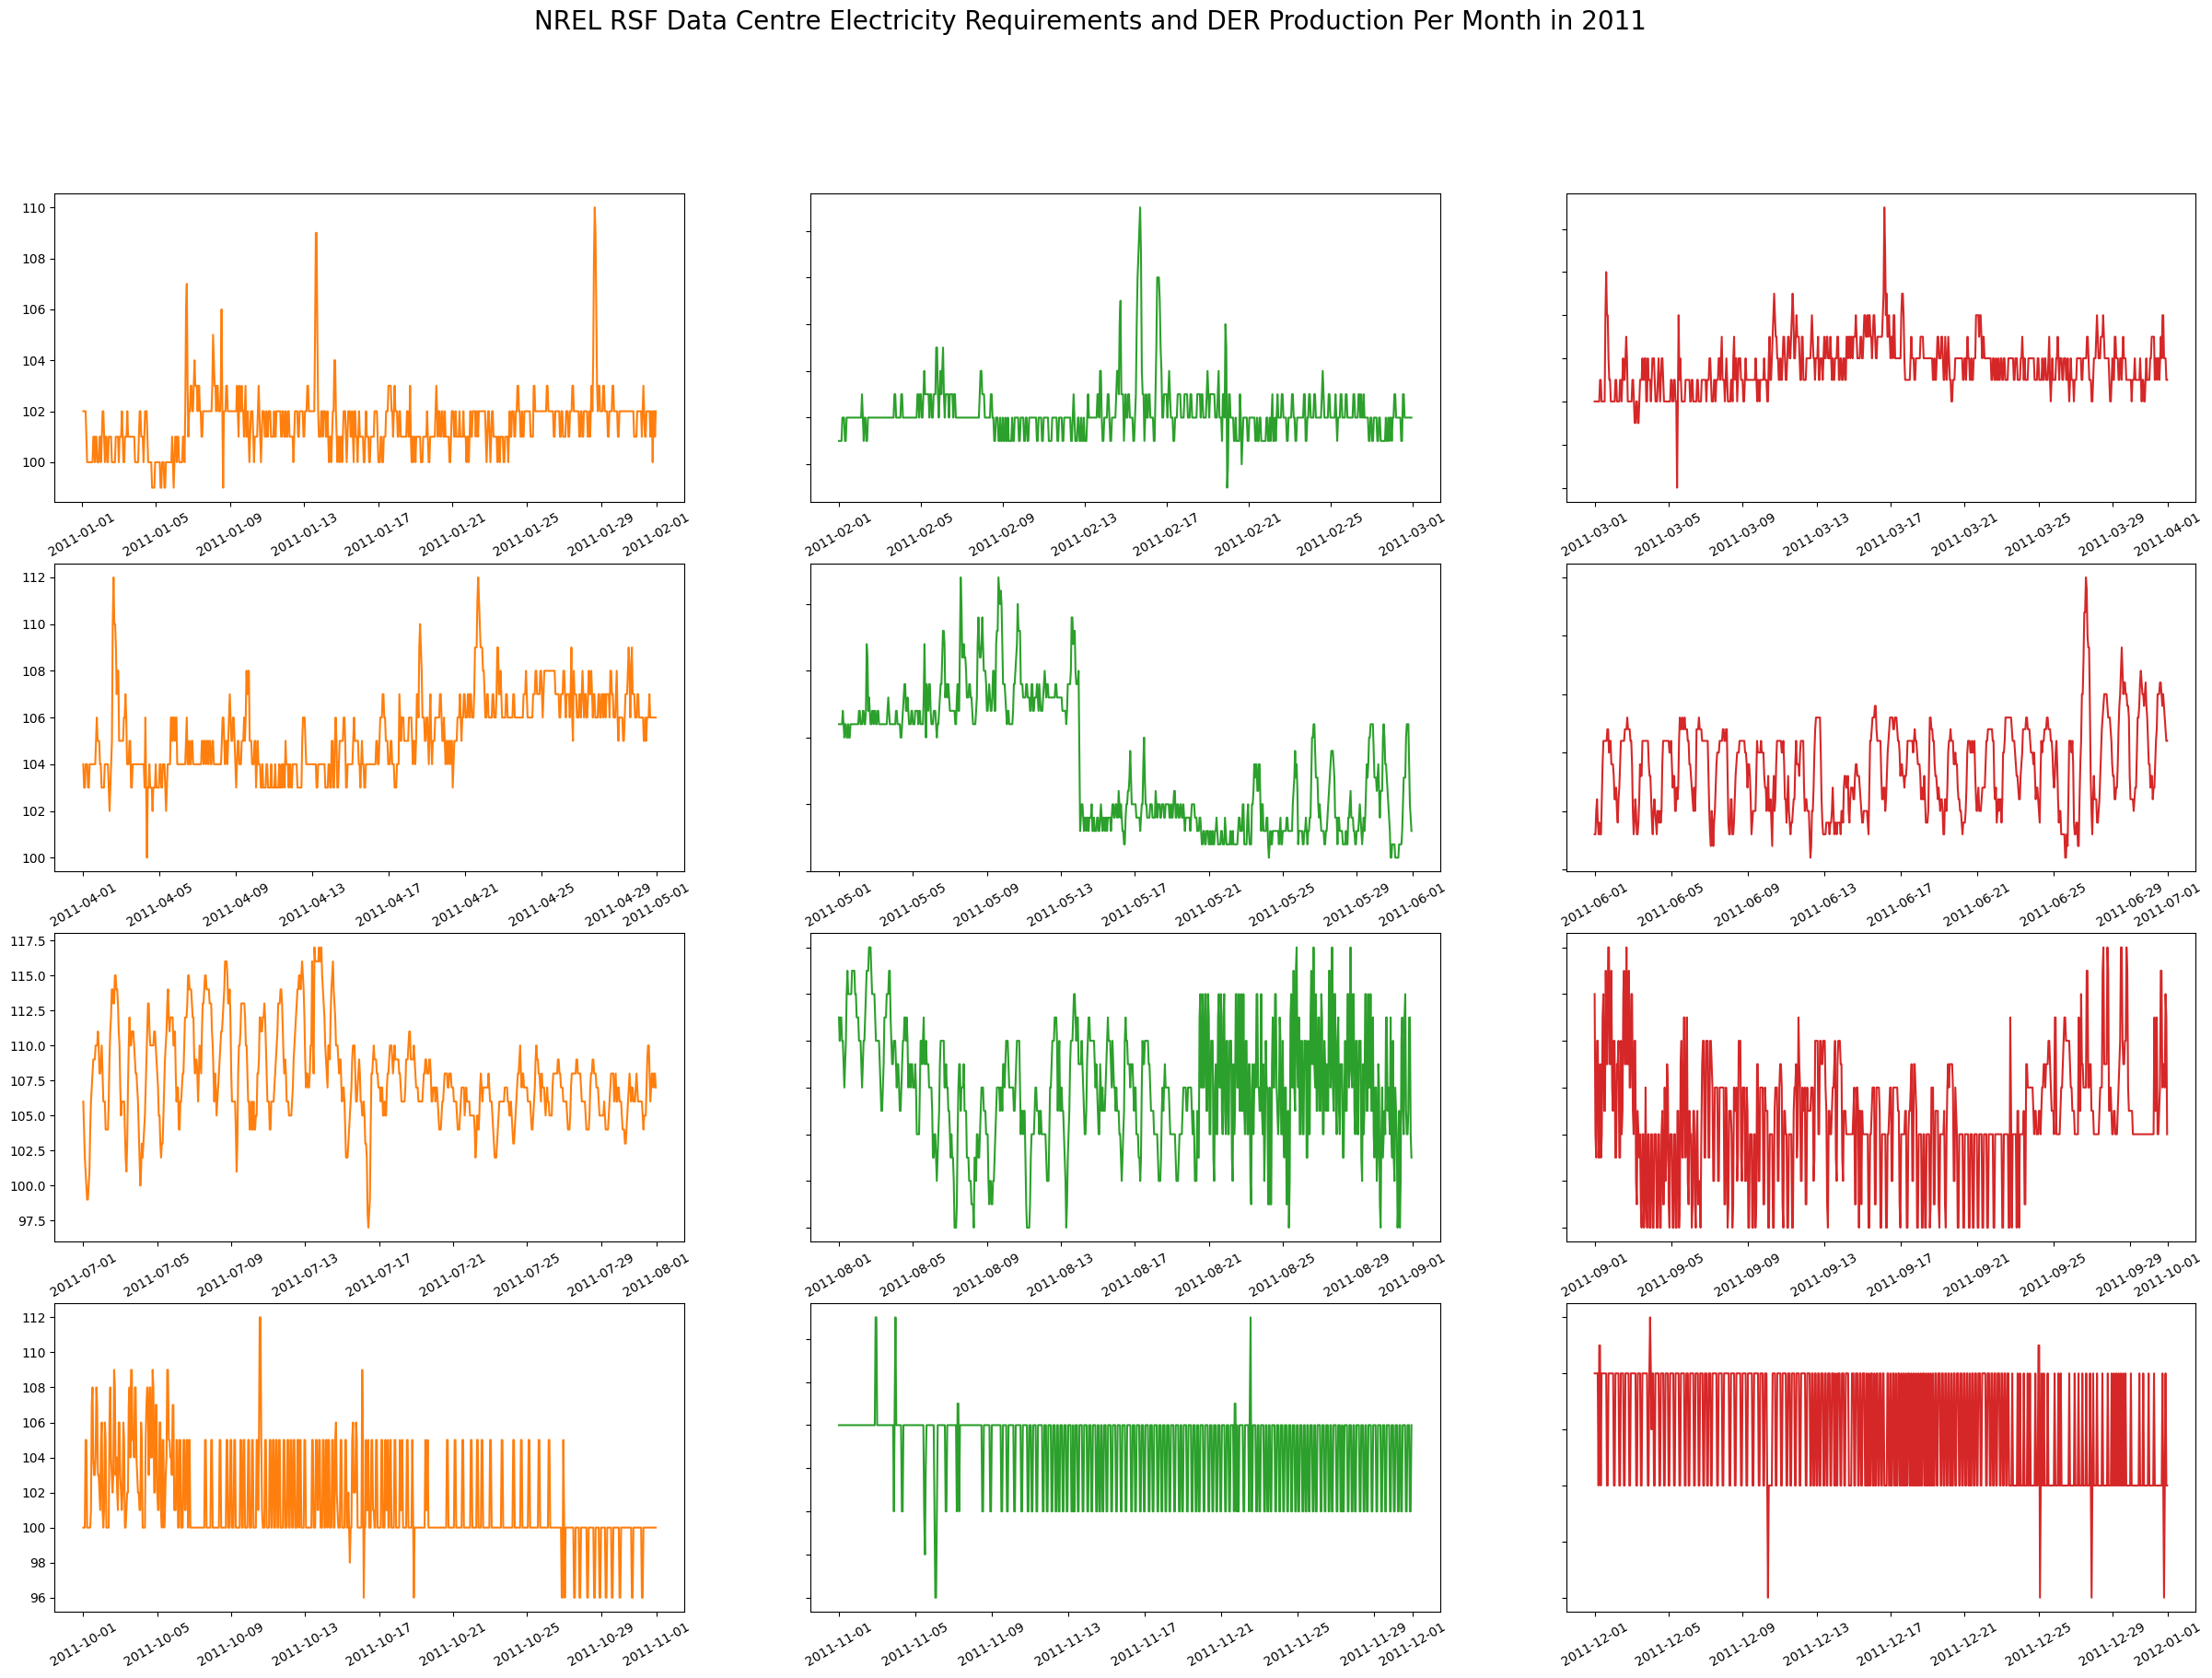

In [27]:
# Creating a complete series of plots of the data centre energy usage during the months of 2011

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6),(ax7, ax8, ax9),(ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(30,20))



fig.suptitle('NREL RSF Data Centre Electricity Requirements and DER Production Per Month in 2011', fontsize=20)
ax1.plot(df_1.index, df_1['kWh Total Data Centre'], 'tab:orange')
ax2.plot(df_2.index, df_2['kWh Total Data Centre'], 'tab:green')
ax3.plot(df_3.index, df_3['kWh Total Data Centre'], 'tab:red')
ax4.plot(df_4.index, df_4['kWh Total Data Centre'], 'tab:orange')
ax5.plot(df_5.index, df_5['kWh Total Data Centre'], 'tab:green')
ax6.plot(df_6.index, df_6['kWh Total Data Centre'], 'tab:red')
ax7.plot(df_7.index, df_7['kWh Total Data Centre'], 'tab:orange')
ax8.plot(df_8.index, df_8['kWh Total Data Centre'], 'tab:green')
ax9.plot(df_9.index, df_9['kWh Total Data Centre'], 'tab:red')
ax10.plot(df_10.index, df_10['kWh Total Data Centre'], 'tab:orange')
ax11.plot(df_11.index, df_11['kWh Total Data Centre'], 'tab:green')
ax12.plot(df_12.index, df_12['kWh Total Data Centre'], 'tab:red')


for ax in fig.get_axes():
    ax.label_outer()
    ax.tick_params(axis='x', labelrotation=30, labelbottom=True, labelsize=10);


The data centre energy use is quite stable and consistent.

In [28]:
# Maximum DC electricity consumption (kWh)
df["kWh Total Data Centre"].max()

120.0

In [29]:
# Maximum DC electricity consumption (kWh)
df["kWh Total Data Centre"].min()

92.0

In [30]:
# Mean DC electricity consumption (kWh)
round(df["kWh Total Data Centre"].mean(),0)

102.0

In [31]:
# Monthly electricity usage of the NREL RSF data centre
monthly_dc_total_power = pd.DataFrame(df.groupby(df['Month'])['kWh Total Data Centre'].sum())
monthly_dc_total_power

,kWh Total Data Centre
Month,
1,75304.0
2,68672.0
3,77105.0
4,75809.0
5,76592.0
6,74690.0
7,80157.0
8,77355.0
9,72403.0


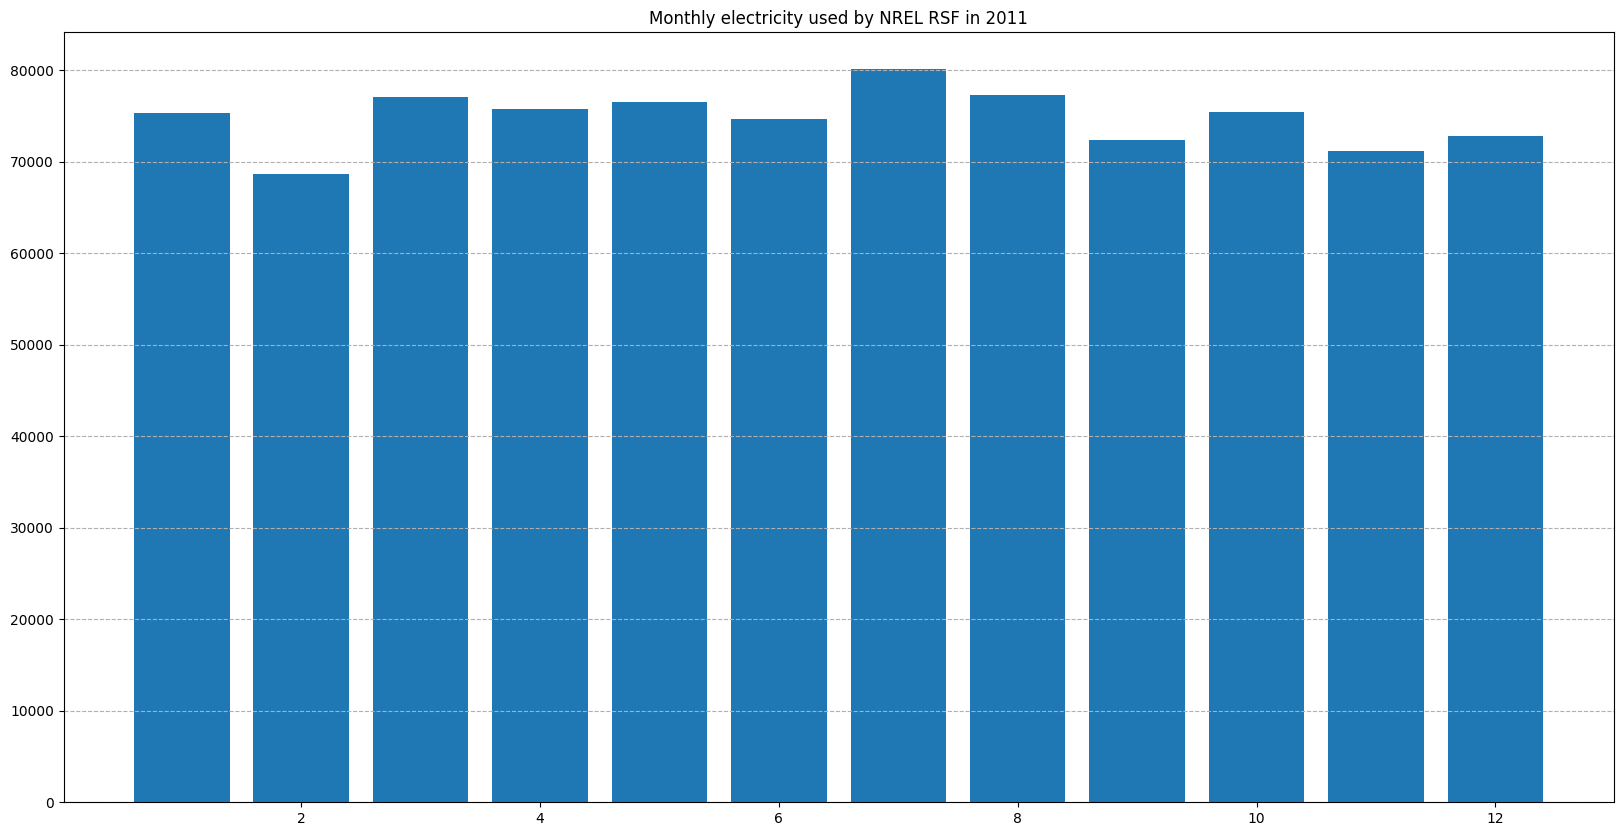

In [32]:
# The monthly energy use also has modest fluctuations.
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='y', linestyle='--')
plt.title('Monthly electricity used by NREL RSF in 2011')
plt.bar(monthly_dc_total_power.index, monthly_dc_total_power["kWh Total Data Centre"]);

In [33]:
# Generating a dataset for a specific day (1st July 2011)
df_2011_07_01 = df[(df.index>= '2011/07/01 0:00') & (df.index < '2011/07/02 0:00')]


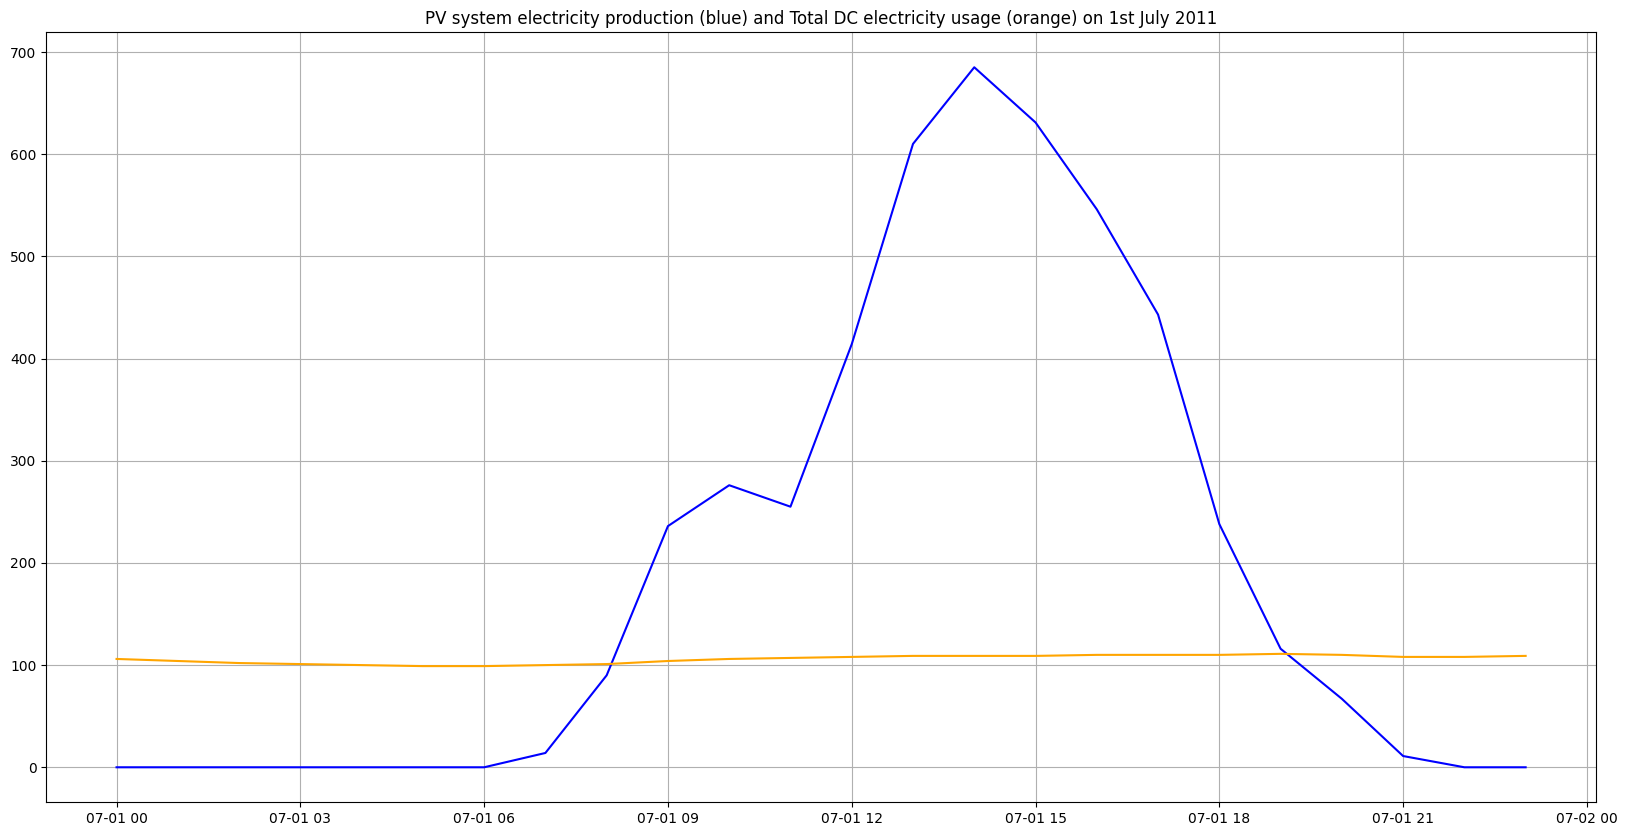

In [34]:
# Even in a typical 'net zero' day (i.e., the energy produced by the PV system is equal to or more than the required energy),
#the PV system can only cover the needs of the data centre, roughly between 8am and 7pm.

plt.figure(figsize=(20, 10))
plt.grid()
plt.title('PV system electricity production (blue) and Total DC electricity usage (orange) on 1st July 2011')
plt.plot(-df_2011_07_01['kWh PV'], color="blue")
plt.plot(df_2011_07_01['kWh Total Data Centre'], color="orange");

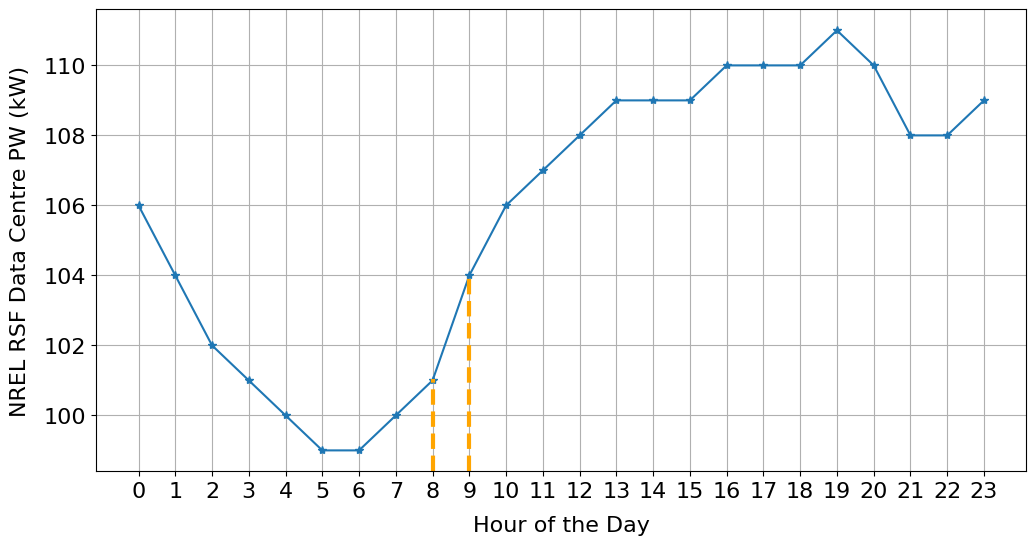

In [35]:
# Creation of Fig. 3.2: Example of trapezoidal integration using as an example the PV data for July 1st
plt.figure(figsize=(12, 6))
plt.grid()
x = df_2011_07_01.index.hour.tolist()
y = df_2011_07_01['kWh Total Data Centre'].tolist()
font1 = {'color':'k','size':16}
font2 = {'color':'k','size':14}
plt.xticks(np.arange(0, 24, 1.0), fontsize="16")
plt.yticks(fontsize="16")
plt.xlabel("Hour of the Day", fontdict=font1, labelpad=10)
plt.ylabel("NREL RSF Data Centre PW (kW)", fontdict=font1, labelpad=10)
plt.plot(x, y, marker= "*")
plt.axvline(x=8, ymin=0, ymax=0.2, color = "orange", linestyle = "--", linewidth=3)
plt.axvline(x=9, ymin=0, ymax=0.42, color = "orange", linestyle = "--", linewidth=3)
plt.savefig("trap_int.jpg", dpi=300)


In [36]:
# Minimum electricity used by the data centre in year 2011 for every hour of the day
DC_hour_min = pd.DataFrame(df.groupby([df.index.hour])["kWh Total Data Centre"].min()).reset_index()
DC_hour_min = DC_hour_min.rename(columns={"Date and Time":"Hour", "kWh Total Data Centre":"Min kWh DC"}).set_index("Hour")

In [37]:
# Mean electricity used by the data centre in year 2011 for every hour of the day
DC_hour_mean = pd.DataFrame(df.groupby([df.index.hour])["kWh Total Data Centre"].mean().round(1)).reset_index()
DC_hour_mean = DC_hour_mean.rename(columns={"Date and Time":"Hour", "kWh Total Data Centre":"Mean kWh DC"}).set_index("Hour")

In [38]:
# Maximum electricity used by the data centre in year 2011 for every hour of the day
DC_hour_max = pd.DataFrame(df.groupby([df.index.hour])["kWh Total Data Centre"].max()).reset_index()
DC_hour_max = DC_hour_max.rename(columns={"Date and Time":"Hour", "kWh Total Data Centre":"Max kWh DC"}).set_index("Hour")

In [39]:
# Putting all together
DC_hour_el_use = pd.merge(pd.merge(DC_hour_min,DC_hour_mean,left_index=True, right_index=True), DC_hour_max , left_index=True, right_index=True)
DC_hour_el_use

,Min kWh DC,Mean kWh DC,Max kWh DC
Hour,,,
0,96.0,102.2,113.0
1,92.0,101.8,112.0
2,92.0,101.7,110.0
3,96.0,102.2,110.0
4,96.0,102.1,109.0
5,96.0,101.6,108.0
6,96.0,101.3,110.0
7,96.0,101.2,110.0
8,96.0,101.4,110.0


In [40]:
# Mean electricity needed by the data centre across all hours of the year 2011

round(sum(DC_hour_el_use['Mean kWh DC'].tolist())/24, 1)

102.5

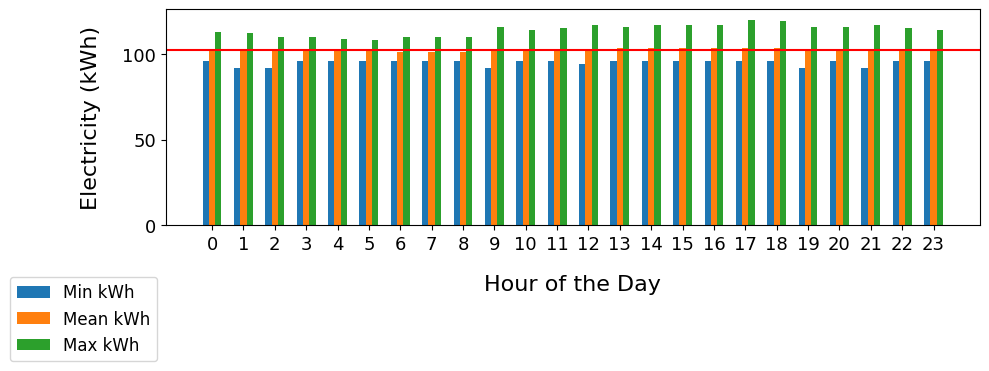

In [41]:
# Creation of Fig. 2.1: Variation in Energy Usage During the Day
fig, ax = plt.subplots(figsize=(10,4))
x_axis = DC_hour_el_use.index
min = DC_hour_el_use['Min kWh DC']
mean = DC_hour_el_use['Mean kWh DC']
max = DC_hour_el_use['Max kWh DC']

font1 = {'color':'k','size':20}
font2 = {'color':'k','size':16}
font3 = {'color':'k','size':10}


width = 0.2
ax.bar(x_axis-width, min, width, label = 'Min kWh', )
ax.bar(x_axis, mean, width, label = 'Mean kWh')
ax.bar(x_axis+width, max, width, label = 'Max kWh')
plt.axhline(y=102.5, color="red")
ax.legend(bbox_to_anchor=(0, -0.2), loc="upper right", fontsize=12)
ax.set_xticks(x_axis)
ax.set_xlabel('Hour of the Day', fontdict=font2, labelpad=15)
ax.set_ylabel('Electricity (kWh)', fontdict=font2, labelpad=15)
plt.tight_layout()
plt.tick_params(labelsize=13)
plt.show()
fig.savefig('var_energy.jpg', dpi=300);

# 6- Performance Factor of the Photovoltaic System

In [42]:
cap = 450 # Installed capacity of the NREL RSF PV System (in kW)

In [43]:
df_1

,Day of Week,Total Cooling (kW),Total Heating (kW),Total Mechanical (kW),Total Lighting (kW),Total Plug Loads (kW),Total Data Center (kW),Total Building (kW),PV (kW),Building Net (kW),Month,Day,Hour,kWh Total Data Centre,kWh Total Building,kWh PV,kWh Building Net,Percentage of Energy Grid,Bool
Date and Time,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,Saturday,0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,1,1,0,NaN,NaN,NaN,NaN,100.0,Grid
2011-01-01 01:00:00,Saturday,0,936,8.0,4.0,32.0,102.0,1080,0.0,1080.0,1,1,1,NaN,540.0,NaN,NaN,100.0,Grid
2011-01-01 02:00:00,Saturday,0,838,8.0,4.0,30.0,102.0,978,0.0,978.0,1,1,2,102.0,1029.0,0.0,1029.0,100.0,Grid
2011-01-01 03:00:00,Saturday,0,904,8.0,4.0,32.0,102.0,1046,0.0,1046.0,1,1,3,102.0,1012.0,0.0,1012.0,100.0,Grid
2011-01-01 04:00:00,Saturday,0,838,10.0,4.0,34.0,102.0,984,0.0,984.0,1,1,4,102.0,1015.0,0.0,1015.0,100.0,Grid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-01-31 19:00:00,Monday,0,838,12.0,36.0,42.0,100.0,1026,0.0,1026.0,1,31,19,100.0,905.0,0.0,905.0,100.0,Grid
2011-01-31 20:00:00,Monday,0,420,8.0,32.0,38.0,104.0,598,0.0,598.0,1,31,20,102.0,812.0,0.0,812.0,100.0,Grid
2011-01-31 21:00:00,Monday,0,1032,10.0,28.0,38.0,100.0,1206,0.0,1206.0,1,31,21,102.0,902.0,0.0,902.0,100.0,Grid


''

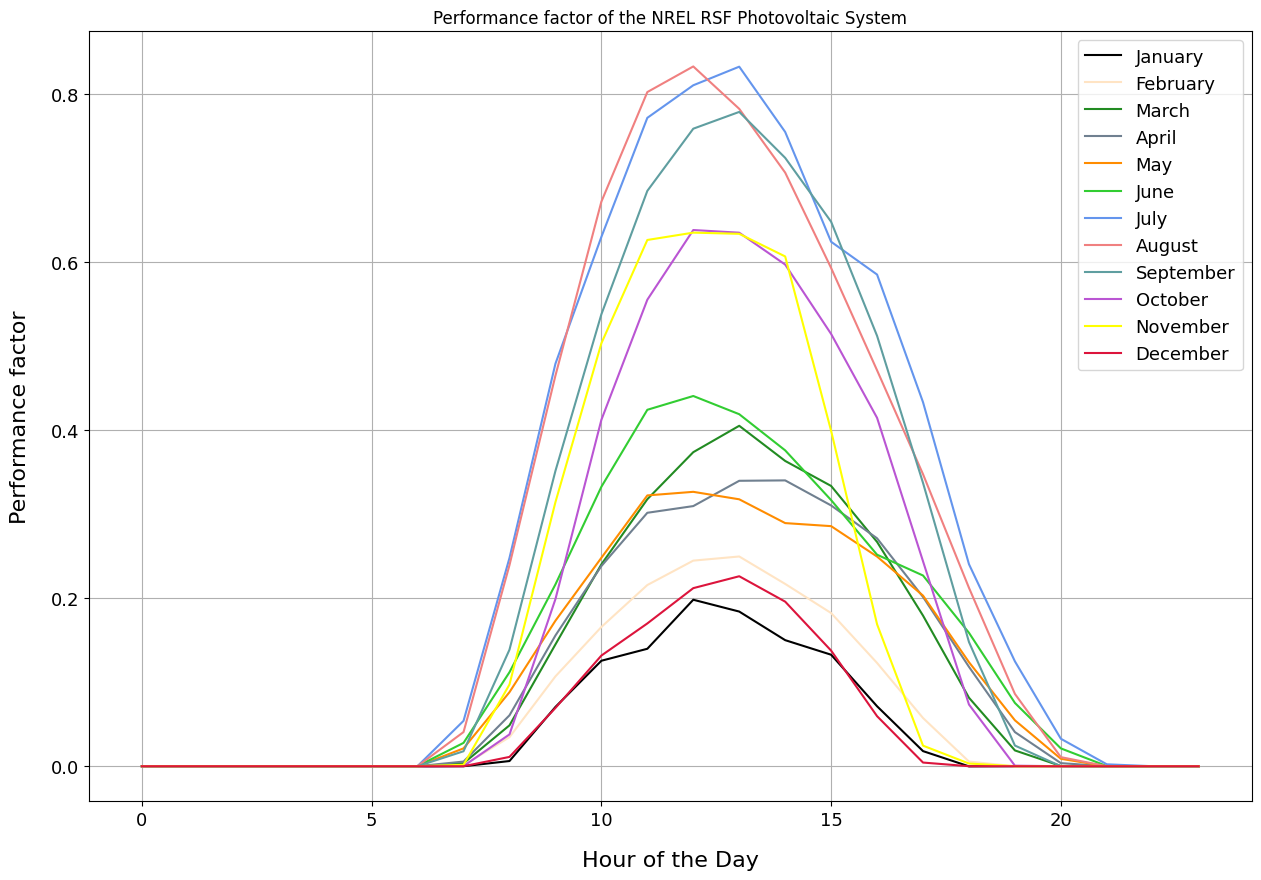

In [46]:
#Generating the plot of the performance factor

#for i in range(1,2):
df_pf_1 = pd.DataFrame(df_1.groupby(["Hour"])['PV (kW)'].mean())
df_pf_2 = pd.DataFrame(df_2.groupby(["Hour"])['PV (kW)'].mean())
df_pf_3 = pd.DataFrame(df_3.groupby(["Hour"])['PV (kW)'].mean())
df_pf_4 = pd.DataFrame(df_4.groupby(["Hour"])['PV (kW)'].mean())
df_pf_5 = pd.DataFrame(df_5.groupby(["Hour"])['PV (kW)'].mean())
df_pf_6 = pd.DataFrame(df_6.groupby(["Hour"])['PV (kW)'].mean())
df_pf_7 = pd.DataFrame(df_7.groupby(["Hour"])['PV (kW)'].mean())
df_pf_8 = pd.DataFrame(df_8.groupby(["Hour"])['PV (kW)'].mean())
df_pf_9 = pd.DataFrame(df_9.groupby(["Hour"])['PV (kW)'].mean())
df_pf_10 = pd.DataFrame(df_10.groupby(["Hour"])['PV (kW)'].mean())
df_pf_11 = pd.DataFrame(df_11.groupby(["Hour"])['PV (kW)'].mean())
df_pf_12 = pd.DataFrame(df_12.groupby(["Hour"])['PV (kW)'].mean())

plt.figure(figsize=(15, 10))
plt.grid()
plt.title('Performance factor of the NREL RSF Photovoltaic System')
plt.plot(-df_pf_1['PV (kW)']/711, color="black", label = "January")
plt.plot(-df_pf_2['PV (kW)']/711, color="bisque", label = "February")
plt.plot(-df_pf_3['PV (kW)']/711, color="forestgreen", label = "March")
plt.plot(-df_pf_4['PV (kW)']/711, color="slategrey", label = "April")
plt.plot(-df_pf_5['PV (kW)']/711, color="darkorange", label = "May")
plt.plot(-df_pf_6['PV (kW)']/711, color="limegreen", label = "June")
plt.plot(-df_pf_7['PV (kW)']/711, color="cornflowerblue", label = "July")
plt.plot(-df_pf_8['PV (kW)']/711, color="lightcoral", label = "August")
plt.plot(-df_pf_9['PV (kW)']/711, color="cadetblue", label = "September")
plt.plot(-df_pf_10['PV (kW)']/711, color="mediumorchid", label = "October")
plt.plot(-df_pf_11['PV (kW)']/711, color="yellow", label = "November")
plt.plot(-df_pf_12['PV (kW)']/711, color="crimson", label = "December")
plt.xlabel('Hour of the Day', fontdict=font2, labelpad=15)
plt.ylabel('Performance factor', fontdict=font2, labelpad=15)
plt.tick_params(labelsize=13)
plt.legend(fontsize = 13)
;